In [1]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, TiDEModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from pytorch_forecasting.models import TimeXer
import matplotlib.collections as mcoll 
from matplotlib.gridspec import GridSpec
from pytorch_forecasting.models.nhits import NHiTS




In [2]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
df = pd.read_csv("data/timexer.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [7]:
df.head()

,date,bytes_op0,bytes_op1,bytes_sum,io_count,read_ops_count,write_ops_count,bytes_sum_ema_short,bytes_sum_ema_long,bytes_sum_macd,bytes_sum_macd_signal,duration_sum,time_idx,series_id
0,2024-12-05 13:07:35,20982.0,10491.0,31473.0,5.0,4.0,1.0,31473.000000,31473.000000,0.000000,0.000000,0.000310,0,0
1,2024-12-05 13:07:36,31473.0,31473.0,62946.0,9.0,6.0,3.0,37195.363636,32504.901639,4690.461997,446.710666,0.000575,1,0
2,2024-12-05 13:07:37,31473.0,31473.0,62946.0,9.0,6.0,3.0,41877.297521,33502.970438,8374.327083,1201.721754,0.000587,2,0
3,2024-12-05 13:07:38,31473.0,41964.0,73437.0,10.0,6.0,4.0,47615.425244,34812.282883,12803.142361,2306.618954,0.000600,3,0
4,2024-12-05 13:07:39,31473.0,20982.0,52455.0,8.0,6.0,2.0,48495.347927,35390.732624,13104.615303,3334.999559,0.000483,4,0


In [4]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [5]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [6]:
max_encoder_length = 50
max_prediction_length = 1
static_categoricals = []
static_reals = []
time_varying_known_reals = [
    "bytes_op0","bytes_op1","bytes_sum","io_count",
    "read_ops_count","write_ops_count",
    "bytes_sum_ema_short","bytes_sum_ema_long",
    "bytes_sum_macd","bytes_sum_macd_signal",
]
time_varying_unknown_reals = ["duration_sum"]
group_ids = ["series_id"]
target = "duration_sum"
batch_size = 64
epochs = 50



In [7]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [8]:
model_kwargs = dict(
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 0.99,0.999]),  
    output_size=11,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=10,
    reduce_on_plateau_patience=4,
)


In [9]:
trainer_kwargs = dict(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
)

In [10]:
# Horizons to run
horizon = 20

In [11]:
training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=horizon,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
       scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    )
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=False)

    # Dataloaders
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=False)
test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [ ]:
# model_20 = TemporalFusionTransformer.load_from_checkpoint("ckpts/horizon_20/best-epoch=02-val_loss=0.0006.ckpt")
model_20 = TemporalFusionTransformer.load_from_checkpoint("checkpoints/horizon_20/best-epoch=03-val_loss=0.0006.ckpt")
raw_outputs = model_20.predict(
    test_loader,
    mode="raw",           # full model outputs, including the `prediction` tensor
    return_x=False,       # we only want the model outputs
    return_y=False,
    batch_size=batch_size,
    num_workers=0
)

# 2. Extract the prediction tensor: shape = (n_windows, prediction_length, n_quantiles)
#    In PyTorch Forecasting v0.10+, raw_outputs is an AttributeDict, so:
pred_tensor = raw_outputs["prediction"]  
# it’s a torch.Tensor; move to CPU/NumPy:
preds = pred_tensor.detach().cpu().numpy()  
# Now `preds.shape == (n_windows, horizon, n_quantiles)`

# 3. Gather the true values in the same sliding-window order:
#    This is the concatenation of the decoder’s true targets that your dataset would produce.
actuals = np.concatenate([
    y.detach().cpu().numpy()
    for _, (y, _) in iter(test_loader)
], axis=0)
# actuals.shape == (n_windows, horizon)

# 4. Compute MSE for each quantile over **all** time-steps & windows:
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 0.99,0.999]  # e.g. [0.1, 0.5, 0.9]
for q_idx, q in enumerate(quantile_levels):
    # flatten windows × time-steps into one long vector
    q_preds = preds[:, :, q_idx].reshape(-1)
    y_true = actuals.reshape(-1)
    mse_q = mean_squared_error(y_true, q_preds)
    print(f"Quantile {q:>4.2f} — MSE = {mse_q:.6f}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/examples/checkpoints/horizon_20/best-epoch=03-val_loss=0.0006.ckpt'

In [223]:
raw_predictions = model_20.predict(
    test_loader,
    mode="raw",
    return_x=True,
 
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


In [234]:
timexer = TimeXer.load_from_checkpoint("checkpoints_timexer/horizon_20/best-epoch=00-val_loss=0.0000.ckpt")
tx_raw  = timexer.predict(
    test_loader
)
tide = TiDEModel.load_from_checkpoint("checkpoints_tide/horizon_20/best-epoch=03-val_loss=0.0000.ckpt")
tide_raw = tide.predict(
    test_loader
)

print(tx_raw.shape,tide_raw.shape)


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

torch.Size([39746, 20]) torch.Size([39746, 20])


In [235]:
idx = 820
# tx_raw = tx_raw.detach().cpu().numpy()

tx_seq       = tx_raw[idx].detach().cpu().numpy()
tide_seq = tide_raw[idx].detach().cpu().numpy()
horizon = tx_seq.shape[0]
hist_ts  = np.arange(-50, 0)
fut_ts   = np.arange(0, horizon)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


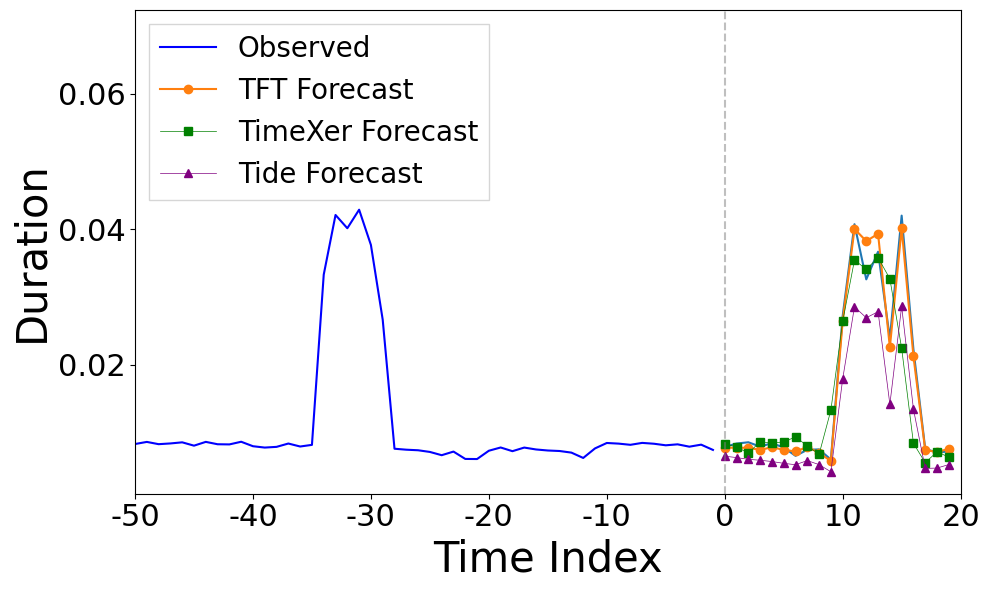

In [236]:
idx = 820

fig, ax = plt.subplots(figsize=(10,6))

# 1) Draw TFT’s full observed (history + future) and its own forecast
model_20.plot_prediction(
    raw_predictions.x,
    raw_predictions.output,
    idx=idx,
    plot_attention=False,
    ax=ax
)

if ax.get_legend() is not None:
    ax.get_legend().remove()

# Remove any Figure‐level legends
for lg in list(fig.legends):
    lg.remove()
fig.legends.clear()

# 2) Remove the quantile‐shaded bands
for coll in list(ax.collections):
    if isinstance(coll, mcoll.PolyCollection):
        coll.remove()

# 3) Recolor everything “observed” to blue
#    (this catches both the t<0 and t>=0 segments)
for line in ax.get_lines():
    if line.get_label().lower().startswith("observed"):
        line.set_color("blue")
        # line.set_linewidth(2.5) 
        # line.set_linestyle("-")
        line.set_label("Observed")

# 4) Recolor TFT’s forecast to red dotted
tft_line = next(l for l in ax.get_lines() if "predicted" in l.get_label().lower())
tft_line.set_color("#ff7f0f")
# tft_line.set_linestyle("--")
tft_line.set_marker("o")
line.set_linewidth(0.5)
tft_line.set_label("TFT Forecast")

# 5) Determine the forecast horizon
horizon = len(tft_line.get_xdata())
fut_ts   = np.arange(0, horizon)

# 6) Overlay TimeXer and Tide
ax.plot(
    fut_ts, tx_seq,
    color="green", label="TimeXer Forecast",
    marker="s",
    linewidth=0.5
)
ax.plot(
    fut_ts, tide_seq,
    color="purple",  label="Tide Forecast",
    marker="^",
    linewidth=0.5
)

# 7) Build a single legend with four entries
observed = next(l for l in ax.get_lines() if l.get_label()=="Observed")
tft_fc   = next(l for l in ax.get_lines() if l.get_label()=="TFT Forecast")
tx_fc    = next(l for l in ax.get_lines() if l.get_label()=="TimeXer Forecast")
tide_fc  = next(l for l in ax.get_lines() if l.get_label()=="Tide Forecast")

ax.legend(
    [observed, tft_fc, tx_fc, tide_fc],
    ["Observed","TFT Forecast","TimeXer Forecast","Tide Forecast"],
    loc="upper left",
    fontsize=20,
    frameon=True,
    fancybox=False
)

# 8) Tighten and relabel the x‐axis
all_x = np.hstack([l.get_xdata() for l in [observed, tft_fc, tx_fc, tide_fc]])
ax.set_xlim(all_x.min(), all_x.max())
ax.margins(x=0)

# force last tick to be 20
ticks = ax.get_xticks()
ticks[-1] = 20
ax.set_xticks(ticks)
ax.set_xticklabels([str(int(t)) for t in ticks], fontsize=22)

# 9) Final styling
ax.tick_params(axis="both", labelsize=22)
ax.set_xlabel("Time Index", fontsize=30)
ax.set_ylabel("Duration",   fontsize=30)
ax.axvline(0, color="gray", linestyle="--", alpha=0.5)
# ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
fig.savefig("plots/horizon_20_all_models.eps", format="eps", dpi=300)
plt.show()

In [219]:
import glob
# Your quantile levels and horizons
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999]
horizons = [1, 5, 10, 15, 20]  # adjust as needed
batch_size = 64 
results = []               # whatever you used

for h in horizons:
    ckpt_dir = f"ckpts_11_no_static/horizon_{h}"
    ckpt = glob.glob(os.path.join(ckpt_dir, "*.ckpt"))
    assert len(ckpt)==1, f"need exactly one ckpt in {ckpt_dir}"
    model = TemporalFusionTransformer.load_from_checkpoint(ckpt[0])

    

    raw = model.predict(
        test_loader,
        mode="raw",
        return_x=False, return_y=False,
        batch_size=batch_size, num_workers=0
    )
    preds   = raw["prediction"].cpu().numpy()          # (n_windows, h, n_quantiles)
    actuals = np.concatenate(
        [y.cpu().numpy() for _, (y, _) in iter(test_loader)],
        axis=0
    )  # (n_windows, h)

    for qi, q in enumerate(quantile_levels):
        # flatten both windows & timesteps
        errs = preds[:, :, qi].reshape(-1)
        y    = actuals.reshape(-1)
        print(f"H={h}, Q={q}, Unique preds:", np.unique(preds[:, :, qi]).shape[0])

        mse_q = mean_absolute_error(y, errs)
        results.append({"horizon": h, "quantile": q, "mse": mse_q})

df = pd.DataFrame(results)


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=1, Q=0.1, Unique preds: 665961
H=1, Q=0.2, Unique preds: 673402
H=1, Q=0.3, Unique preds: 672197
H=1, Q=0.4, Unique preds: 677671
H=1, Q=0.5, Unique preds: 678104
H=1, Q=0.6, Unique preds: 681992
H=1, Q=0.7, Unique preds: 685385
H=1, Q=0.8, Unique preds: 684395
H=1, Q=0.9, Unique preds: 686435
H=1, Q=0.99, Unique preds: 647992
H=1, Q=0.999, Unique preds: 673583


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=5, Q=0.1, Unique preds: 701646
H=5, Q=0.2, Unique preds: 709287
H=5, Q=0.3, Unique preds: 711086
H=5, Q=0.4, Unique preds: 712468
H=5, Q=0.5, Unique preds: 711996
H=5, Q=0.6, Unique preds: 710471
H=5, Q=0.7, Unique preds: 705643
H=5, Q=0.8, Unique preds: 701214
H=5, Q=0.9, Unique preds: 679496
H=5, Q=0.99, Unique preds: 668894
H=5, Q=0.999, Unique preds: 690784


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=10, Q=0.1, Unique preds: 700612
H=10, Q=0.2, Unique preds: 713692
H=10, Q=0.3, Unique preds: 713610
H=10, Q=0.4, Unique preds: 718200
H=10, Q=0.5, Unique preds: 719266
H=10, Q=0.6, Unique preds: 719445
H=10, Q=0.7, Unique preds: 717678
H=10, Q=0.8, Unique preds: 715262
H=10, Q=0.9, Unique preds: 701442
H=10, Q=0.99, Unique preds: 677638
H=10, Q=0.999, Unique preds: 676396


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=15, Q=0.1, Unique preds: 702869
H=15, Q=0.2, Unique preds: 713824
H=15, Q=0.3, Unique preds: 712473
H=15, Q=0.4, Unique preds: 716626
H=15, Q=0.5, Unique preds: 712267
H=15, Q=0.6, Unique preds: 714996
H=15, Q=0.7, Unique preds: 713836
H=15, Q=0.8, Unique preds: 708550
H=15, Q=0.9, Unique preds: 695955
H=15, Q=0.99, Unique preds: 686039
H=15, Q=0.999, Unique preds: 704701


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

H=20, Q=0.1, Unique preds: 699046
H=20, Q=0.2, Unique preds: 714281
H=20, Q=0.3, Unique preds: 712980
H=20, Q=0.4, Unique preds: 716935
H=20, Q=0.5, Unique preds: 713665
H=20, Q=0.6, Unique preds: 715490
H=20, Q=0.7, Unique preds: 712902
H=20, Q=0.8, Unique preds: 711740
H=20, Q=0.9, Unique preds: 695444
H=20, Q=0.99, Unique preds: 682028
H=20, Q=0.999, Unique preds: 696056


In [220]:
mse_table = df.pivot(index="horizon", columns="quantile", values="mse")
print(mse_table)

quantile     0.100     0.200     0.300     0.400     0.500     0.600  \
horizon                                                                
1         0.001982  0.001675  0.001501  0.001381  0.001294  0.001234   
5         0.001480  0.001154  0.001004  0.000942  0.000934  0.000948   
10        0.001582  0.001139  0.001034  0.000986  0.000971  0.000984   
15        0.001578  0.001164  0.001086  0.001058  0.001033  0.001044   
20        0.001571  0.001181  0.001037  0.000974  0.000956  0.000949   

quantile     0.700     0.800     0.900     0.990     0.999  
horizon                                                     
1         0.001207  0.001193  0.001230  0.001850  0.005351  
5         0.000977  0.001037  0.001288  0.001798  0.006214  
10        0.001000  0.001043  0.001148  0.001600  0.006003  
15        0.001068  0.001105  0.001239  0.001647  0.006906  
20        0.000966  0.000992  0.001089  0.001612  0.005911  


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


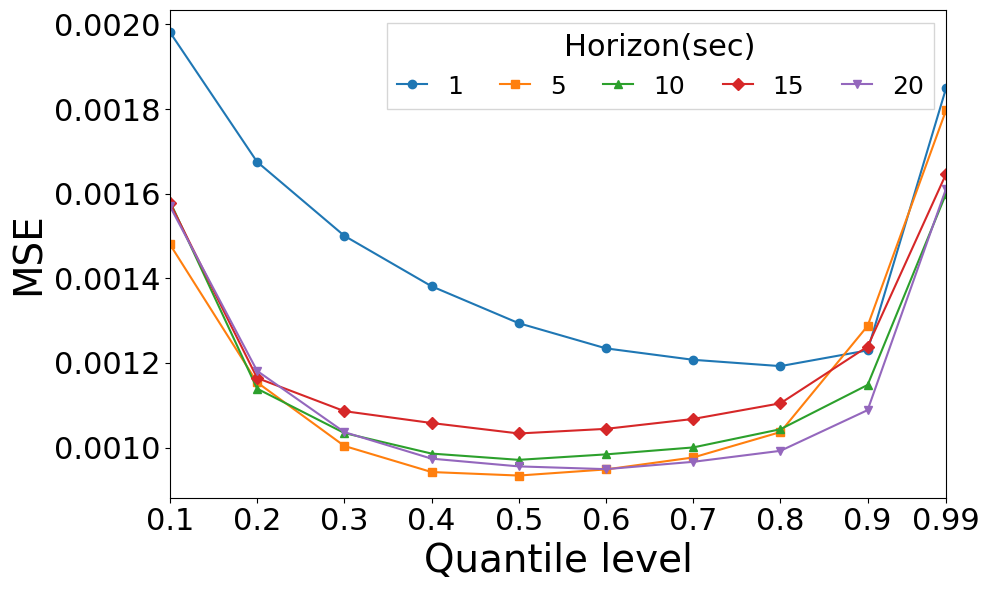

In [221]:
# 1) Drop the 0.999 column
plot_table = mse_table.drop(columns=[0.999])

qs = plot_table.columns.astype(float)
markers = ['o', 's', '^', 'D', 'v']
fig, ax = plt.subplots(figsize=(10,6))
for i, h in enumerate(plot_table.index):
    ax.plot(
        qs,
        plot_table.loc[h].values,
        marker=markers[i % len(markers)],
        label=f"{h}"
    )

# Linear axis with no margins
ax.set_xlim(qs.min(), qs.max())
ax.margins(x=0)

# Ticks at each quantile
ax.set_xticks(qs)
ax.set_xticklabels([str(q) for q in qs], fontsize=22)
ax.tick_params(axis="y", labelsize=22)

# Axis labels
ax.set_xlabel("Quantile level", fontsize=28)
ax.set_ylabel("MSE",      fontsize=28)
ax.yaxis.get_offset_text().set_fontsize(22)
# Legend with larger font
n = len(plot_table.index)
leg = ax.legend(
    title="Horizon(sec)",
    ncol=n,
    fontsize=18,
    title_fontsize=22,
    frameon=True,
    fancybox=False,
    loc="upper right",
    # bbox_to_anchor=(0.98, 0.98),    # (x, y) in axes fraction coords
    handlelength=1.2,
    handleheight=1,
    columnspacing=1.5,
    # borderpad=0.3,
    # labelspacing=1,
)

fig.savefig("plots/mse_q.eps", format="eps",dpi=300,bbox_inches="tight")
fig.tight_layout()

plt.show()


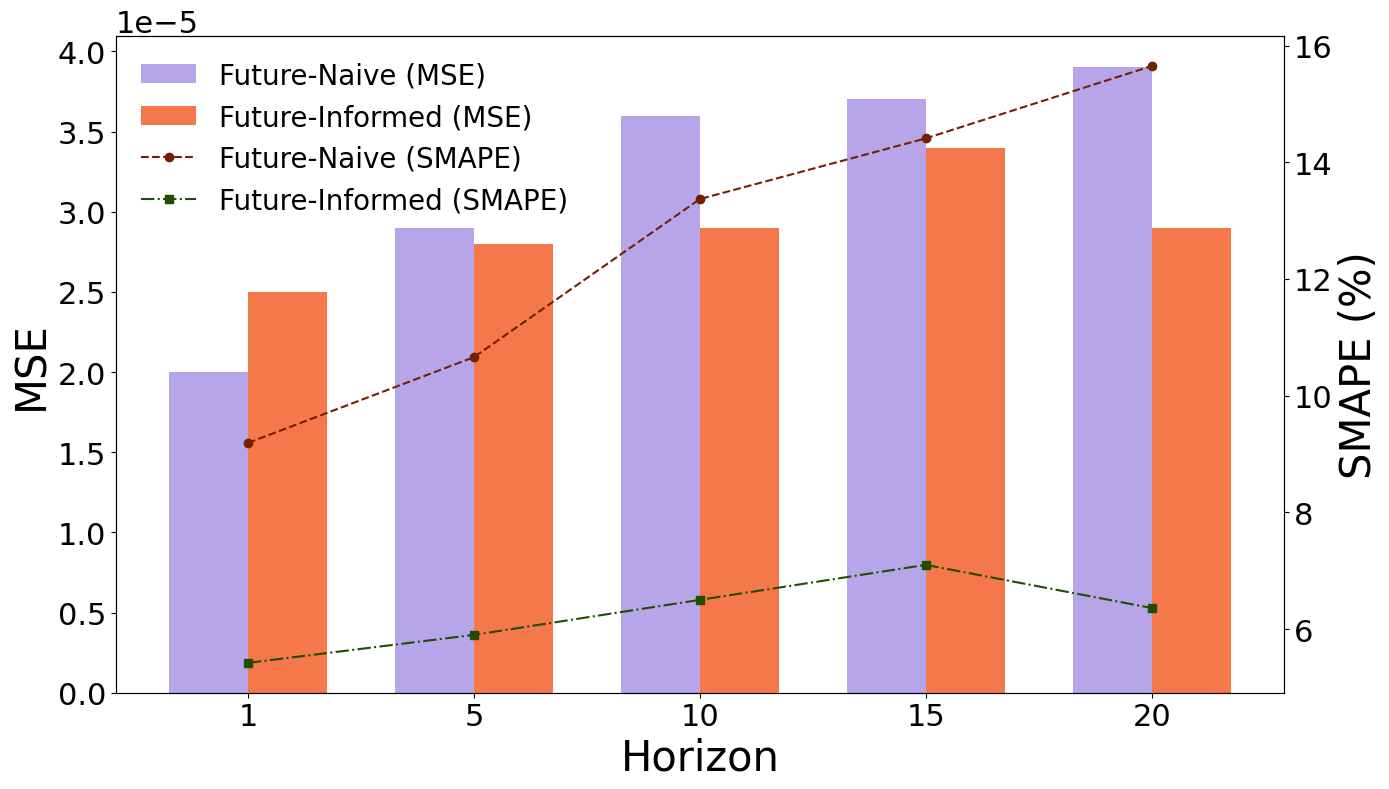

In [3]:
horizons = np.array([1, 5, 10, 15, 20])
mse_unknown   = np.array([2.0e-05, 2.9e-05, 3.6e-05, 3.7e-05, 3.9e-05])
mse_tft       = np.array([2.5e-05, 2.8e-05, 2.9e-05, 3.4e-05, 2.9e-05])
smape_unknown = np.array([ 9.19, 10.66, 13.37, 14.41, 15.65])
smape_tft     = np.array([ 5.42,  5.90,  6.50,  7.10,  6.36])

x = np.arange(len(horizons))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14,8))

# --- Left axis: grouped bars for MSE ---
bars1 = ax1.bar(x - width/2, mse_unknown, width, label="Future-Naive (MSE)",  color="#B6A6E9")
bars2 = ax1.bar(x + width/2, mse_tft,     width, label="Future-Informed (MSE)", color="#F4784A")
ax1.set_ylabel("MSE", fontsize=30)
ax1.tick_params(axis="y", labelsize=22)
ax1.set_xticks(x)
ax1.set_xticklabels(horizons, fontsize=22)
ax1.set_xlabel("Horizon", fontsize=30)
ax1.yaxis.get_offset_text().set_fontsize(22)

# --- Right axis: line plots for SMAPE ---
ax2 = ax1.twinx()
line1, = ax2.plot(x, smape_unknown, marker="o", linestyle="--", color="#731F00", label="Future-Naive (SMAPE)")
line2, = ax2.plot(x, smape_tft,     marker="s", linestyle="-.", color="#204D00", label="Future-Informed (SMAPE)")
ax2.set_ylabel("SMAPE (%)", fontsize=30)
ax2.tick_params(axis="y", labelsize=22)

# --- Combined legend ---
handles = [bars1, bars2, line1, line2]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left", fontsize=20, frameon=False)


plt.tight_layout()
plt.show()


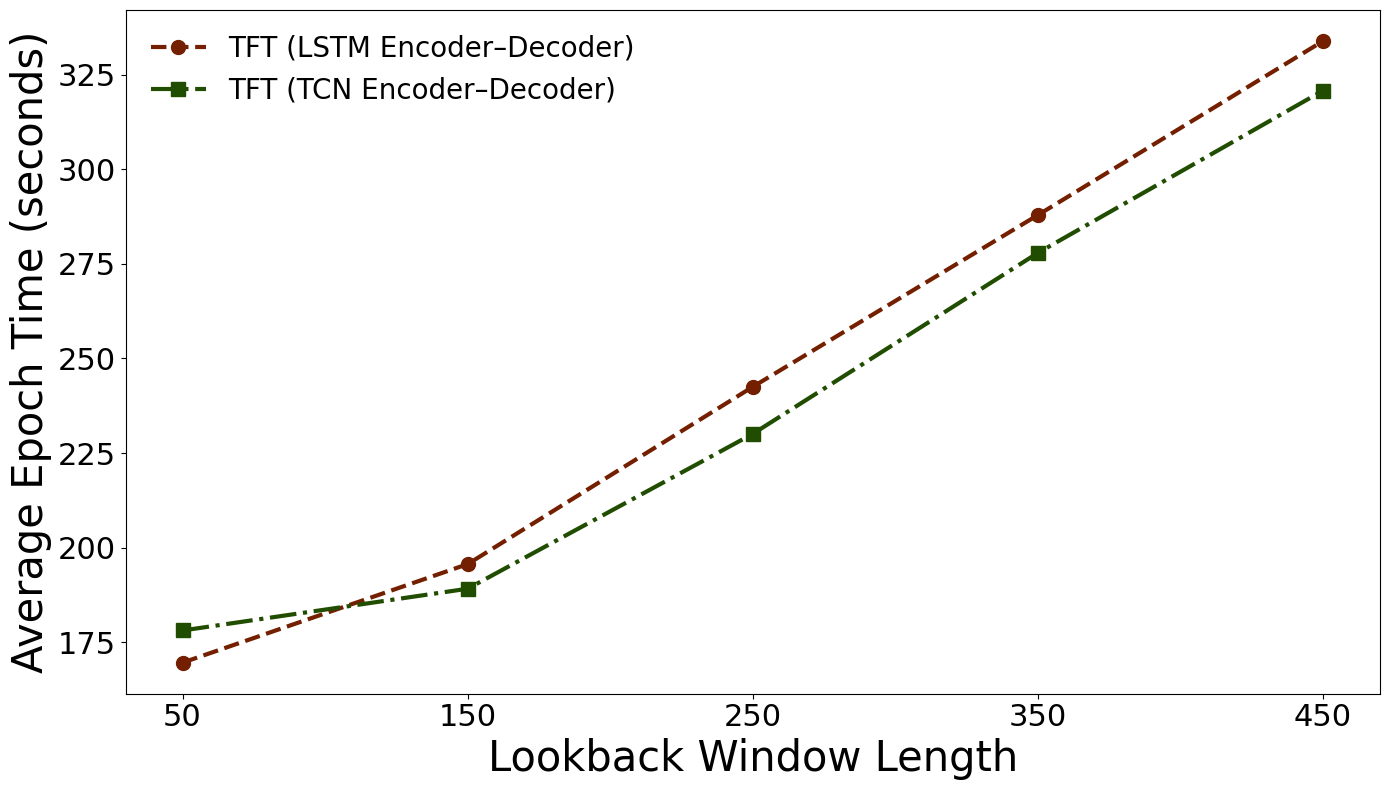

In [3]:
lookbacks = np.array([50, 150, 250, 350, 450])

epoch_time_lstm = np.array([
    169.6,   # L=50
    195.64,   # L=150
    242.51,   # L=250
    287.91,   # L=350
    333.9    # L=450 
])

epoch_time_tcn = np.array([
    178.10,   # L=50
    189.14,   # L=150
    230.07,   # L=250
    277.91,   # L=350
 320.8    # L=450
])

x = np.arange(len(lookbacks))

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

line1, = ax.plot(
    x,
    epoch_time_lstm,
    marker="o",
    linestyle="--",
    linewidth=3,
    markersize=10,
    color="#731F00",
    label="TFT (LSTM Encoder–Decoder)"
)

line2, = ax.plot(
    x,
    epoch_time_tcn,
    marker="s",
    linestyle="-.",
    linewidth=3,
    markersize=10,
    color="#204D00",
    label="TFT (TCN Encoder–Decoder)"
)

# -----------------------------
# Axes formatting
# -----------------------------
ax.set_xlabel("Lookback Window Length", fontsize=30)
ax.set_ylabel("Average Epoch Time (seconds)", fontsize=30)

ax.set_xticks(x)
ax.set_xticklabels(lookbacks, fontsize=22)
ax.tick_params(axis="y", labelsize=22)

# -----------------------------
# Legend
# -----------------------------
ax.legend(
    loc="upper left",
    fontsize=20,
    frameon=False
)

# -----------------------------
# Grid & layout
# -----------------------------
# ax.grid(True, axis="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
